## Etapa 6: Treinando o modelo com uma CNN

Após realizarmos a primeira predição do dataset dos tweets com um modelo SVM, faremos uma nova predição do mesmo, porém utilizando uma rede neural convolucional.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re

from tqdm import tqdm

import keras
from keras.layers import (
    Embedding,
    Conv1D,
    Concatenate,
    GlobalMaxPool1D,
    Dense,
)
from keras import Model
from keras import losses
from keras import Sequential, layers
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.decomposition import PCA
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')


In [2]:
#importa dataset
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)

In [3]:
# função para realizar a predição
def predicao(lista_texto):
    texto_token = tokenizer.texts_to_sequences(lista_texto)
    texto_padded_tokens = pad_sequences(texto_token, maxlen=250)
    return model.predict(texto_padded_tokens[:len(lista_texto)]).argmax(1)   

In [4]:
X_train = train['content']
X_test = test['content']
y_train = train['score']
y_test = test['score']

In [5]:
train['content'] = train['content'].apply(lambda _: str(_))

<AxesSubplot:>

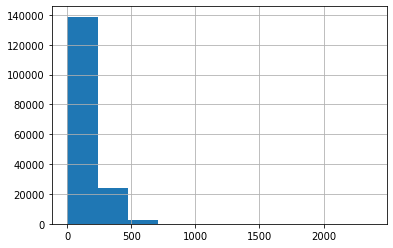

In [6]:
train['content'].apply(len).hist()

In [7]:
#Tokeniza as palavras
tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(X_train)
len(tokenizer.word_index)

44194

In [8]:
train_tokens = tokenizer.texts_to_sequences(X_train)
test_tokens = tokenizer.texts_to_sequences(X_test)

In [9]:
maxlen = 250

In [10]:
#cria padding
padded_train_tokens = pad_sequences(train_tokens, maxlen=maxlen)
padded_test_tokens = pad_sequences(test_tokens, maxlen=maxlen)

padded_train_tokens.shape, padded_test_tokens.shape

((165869, 250), (71088, 250))

In [11]:
#modelar a rede
inputs = keras.Input(shape=(maxlen))
embed = Embedding(input_dim=40000, output_dim=300)(inputs) # matriz de pesos 35 x 300
conv = Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu')(embed) 
pool = GlobalMaxPool1D()(conv) 
classification = Dense(units=2, activation='softmax')(pool)

In [12]:
model = Model(inputs=inputs, outputs=classification)

In [13]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 300)          12000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 250, 64)           57664     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 12,057,794
Trainable params: 12,057,794
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(
    optimizer='adam', 
    loss=losses.CategoricalCrossentropy(),
    metrics=['accuracy']
    )

In [15]:
train_label = to_categorical(y_train, 2)
test_label = to_categorical(y_test, 2)

In [19]:
#treinar
model.fit(x=padded_train_tokens, y=train_label, batch_size=2000, epochs=3)

Epoch 1/2
83/83 [==============================] - 264s 3s/step - loss: 0.0958 - accuracy: 0.9695
Epoch 2/2
83/83 [==============================] - 266s 3s/step - loss: 0.0822 - accuracy: 0.9743


In [20]:
#comparar os resultados
acc = model.evaluate(x=padded_test_tokens, y=test_label)

2222/2222 [==============================] - 33s 15ms/step - loss: 0.1361 - accuracy: 0.9535


In [21]:
# testando com um texto aleatório
texto = ['esta empresa e horrivel']
predicao(texto)

array([0], dtype=int64)

In [22]:
#verificando a precisão da predição
texto_token = tokenizer.texts_to_sequences(texto)
texto_padded_tokens = pad_sequences(texto_token, maxlen=250)
model.predict(texto_padded_tokens[:len(texto)])

array([[0.95013994, 0.04986003]], dtype=float32)

Novamente a acurácia do modelo chegou a  95%, agora vamos realizar a predição no dataset dos tweets, e gravar uma nova coluna.

In [ ]:
dataset = pd.read_csv('dataset_com_sentimento.csv', index_col=0)

In [ ]:
dataset.head()

In [ ]:
y_pred = predicao(dataset.full_text)

In [ ]:
dataset['sentimento_CNN'] = y_pred

In [ ]:
dataset.head()

In [ ]:
dataset.to_csv('dataset_com_sentimento.csv')

print('Arquivo Gravado com Sucesso')